In [79]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import scipy
import requests
from imdbpie import Imdb
import nltk
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import nltk
import collections
import re
import csv
import psycopg2

%matplotlib inline

In [2]:
!pip install imdbpie

In [80]:
imdb = Imdb()
imdb = Imdb(anonymize=True)
top250=pd.DataFrame(imdb.top_250())

In [81]:
top25=top250.iloc[:25,:]
del top25["image"]

In [82]:
movies=top25["tconst"].tolist()



In [83]:
reviewtext = []
Id = []
for x in movies:
    reviews = imdb.get_title_reviews(x, max_results=15)
    for review in reviews:
        Id.append(x)
        reviewtext.append(review.text)
        

In [84]:
movieReviews = pd.DataFrame({"ID": Id, "Reviews": reviewtext})

In [85]:

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
tokens = [tokenizer.tokenize(i) for i in reviewtext]
tag = [nltk.pos_tag(i) for i in tokens]
tag

#use this to select the words that are adjective
adjectives = []
for x in (tag):
    for a,b in x:
        if b == "JJ":
            adjectives.append(a)
        


c = collections.Counter
count = c(adjectives)
mostCommon = [a for a,b in count.most_common(50)]


In [86]:
dfCommon=pd.DataFrame(columns=mostCommon)
newDF =movieReviews.join(dfCommon)
for c, col in enumerate(newDF.columns[2:]):
    for r, row in enumerate(newDF.index):
        reviewLower = newDF.loc[row,"Reviews"].lower()
        if col in reviewLower:
            newDF.loc[row,col]=1
        else:
            newDF.loc[row,col]=0


In [87]:
del newDF["Reviews"]


In [88]:
newDF=newDF.groupby(["ID"],group_keys=False,as_index=False).apply(lambda x:x.iloc[:,1:].max())
top25=top25.join(newDF)


In [89]:
del top25["type"]

In [90]:
from sklearn.preprocessing import MinMaxScaler

y=top25.rating
X=top25.loc[:,"year":]
X["year"]=MinMaxScaler().fit_transform(X["year"].astype(float).reshape(-1,1))


In [91]:
from sklearn.cross_validation import KFold,cross_val_score
from sklearn.tree import DecisionTreeRegressor

cv = KFold(len(y), shuffle=False)
dt = DecisionTreeRegressor(random_state=5)
dtScore = cross_val_score(dt, X, y, cv=cv)
dtScore
dtScore.mean()

-13.05026455026452

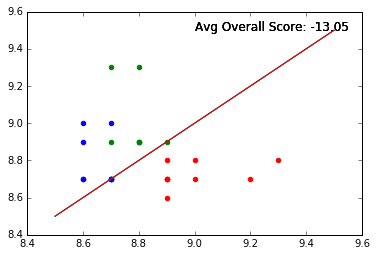

In [92]:
def doPlot(model, m=None):
    for fold, color in zip(cv, ["r", "g", "b"]):
        #print fold
        X_train = X.iloc[fold[0]]
        X_test = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        plt.scatter(y_test, y_pred, color=color)
        plt.plot([8.5,9.5],[8.5,9.5])
        plt.text(9,9.5, "Avg Overall Score: "+str(m), fontsize=12)
        #the 9,9.5 represent the location os "R2: "
    
doPlot(dt, dtScore.mean().round(2))

[ -3.73333333  -6.96571429 -15.475     ] [ -3.72222222 -18.42857143 -17.        ]
-8.72468253968 -13.0502645503


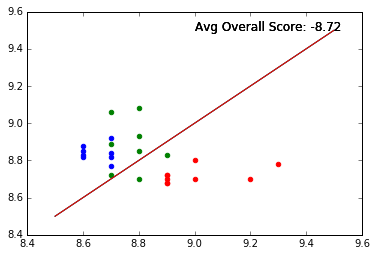

In [93]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

rf = RandomForestRegressor(random_state=5)
rfScore = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
print rfScore, dtScore
print rfScore.mean(), dtScore.mean()
doPlot(rf, rfScore.mean().round(2))

[ -3.83950617  -8.53332973 -18.15940341] [ -3.73333333  -6.96571429 -15.475     ] [ -3.72222222 -18.42857143 -17.        ]
-10.1774131053 -8.72468253968 -13.0502645503


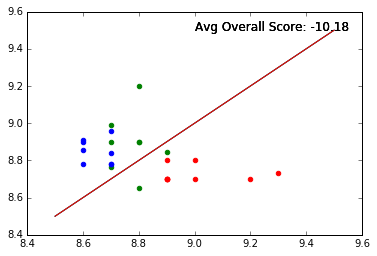

In [94]:
ab = AdaBoostRegressor(random_state=5)

abScore = cross_val_score(ab, X, y, cv=cv, n_jobs=-1)
print abScore, rfScore, dtScore
print abScore.mean(), rfScore.mean(), dtScore.mean()
doPlot(ab, abScore.mean().round(2))

[ -3.62296997 -15.79236283 -16.02698685] [ -3.83950617  -8.53332973 -18.15940341] [ -3.73333333  -6.96571429 -15.475     ] [ -3.72222222 -18.42857143 -17.        ]
-11.8141065504 -10.1774131053 -8.72468253968 -13.0502645503


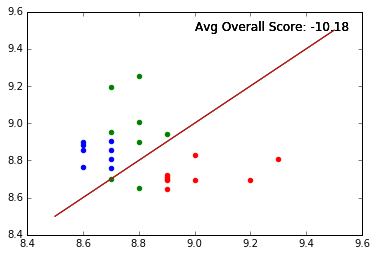

In [95]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=5)

gbScore = cross_val_score(gb, X, y, cv=cv, n_jobs=-1)
print gbScore, abScore, rfScore, dtScore
print gbScore.mean(), abScore.mean(), rfScore.mean(), dtScore.mean()
doPlot(gb, abScore.mean().round(2))

In [96]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [97]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [98]:
preds = treereg.predict(X_test)

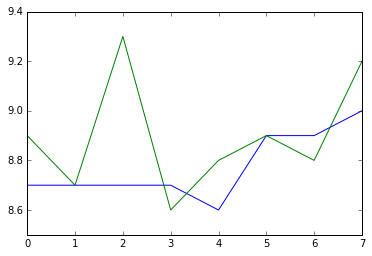

In [99]:
plt.plot(preds)
plt.plot(y_test.values)

In [100]:
from sklearn.metrics import r2_score
r2_score(y_test, preds)

-0.25000000000000422